## V7_MODEL_stacking_1 (xgb+lgb+rf)

In [1]:
import os, sys
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# path 설정
sys.path.append(os.path.dirname(os.path.dirname(os.path.dirname(os.path.abspath("")))))
print(sys.path[-1])

d:\base\boostcamp\apart\level2-competitiveds-recsys-06


In [2]:
raw_path: str = "../../../data/raw"
processed_path: str = "../../../data/processed"
submission_path: str = "../../../data/submission"

In [3]:
v4: pd.DataFrame = pd.read_csv(os.path.join(processed_path,"v4_baek+recent+rank.csv"))

In [4]:
# ARIMA 인덱스 추가
from src.pre_process.deposit.arima_deposit_index import ArimaDepositIndexFeature
interest = pd.read_csv(os.path.join(raw_path, "interestRate.csv"))
v4_arima = ArimaDepositIndexFeature(v4, interest).get_data()
v4_arima_contract_type = pd.get_dummies(v4_arima, columns=['contract_type'], prefix='contract')

d:\Program\Dev\ANACONDA\envs\apart\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


### 컬럼 정리

In [5]:
# columns_to_drop = ['contract_2', 'area_m2_price', 'area_price', 'date', 'contract_ymd', 'original_index', 'interest_rate', 'diff_interest_rate', 'area']
# df = v4_arima_contract_type.drop(columns=columns_to_drop, errors='ignore')

# columns = ['index', 'area_m2', 'floor', 'age', 'latitude', 'longitude', 'apt_idx','nearest_subway_distance', 'category_interchange_within_1km',
#            'deposit', '_type', 'grid_id', 'apt_deposit_rank', 'apt_area_deposit_rank', 'recent_deposit', 
#            'contract_year_month', 'contract_0', 'contract_1', 'infra_score']

columns = ['index','_type','area_m2', 'contract_year_month',
    'floor', 'built_year', 'latitude', 'longitude', 'age',
    'contract_0', 'contract_1',
    'deposit',
    'apt_idx',
    'area',
    'grid_id',
    'nearest_subway_distance',
    'nearest_subway_idx',
    'nearest_elementary_school_distance',
    'nearest_middle_school_distance',
    'nearest_high_school_distance',
    'nearest_park_distance',
    'apt_deposit_rank', 'apt_area_deposit_rank',
    'recent_deposit']
df = v4_arima_contract_type.filter(items=columns)

df['recent_deposit'] = df['recent_deposit'].fillna(39000)
temp_train_df = df[df["_type"]=='train']
test_df = df[df["_type"]=='test']

In [5]:
# from sklearn.preprocessing import StandardScaler

# # 로그 변환할 컬럼들
# columns_to_log_transform = [col for col in df.columns if col not in ['index', 'category_interchange_within_1km', 'contract_0', 'contract_1', 'deposit', '_type']]

# # 0이하값 0으로 변환
# df['floor'] = df['floor'].clip(lower=0)
# df['age'] = df['age'].clip(lower=0)

# # 로그 변환
# for col in columns_to_log_transform:
#     df[col] = np.log1p(df[col])

# df

,index,area_m2,floor,age,latitude,longitude,apt_idx,nearest_subway_distance,category_interchange_within_1km,deposit,_type,grid_id,apt_deposit_rank,apt_area_deposit_rank,recent_deposit,contract_year_month,infra_score
0,0,4.454325,2.302585,0.000000,3.639014,4.852383,0.000000,6.576470,1,17000.0,train,10.149677,8.946896,10.285377,10.571343,12.215562,0.717059
1,1,4.454325,3.044522,0.693147,3.639014,4.852383,0.000000,6.576470,1,23000.0,train,10.149677,8.946896,10.285377,9.741027,12.216043,0.717059
2,2,4.454325,2.197225,0.693147,3.639014,4.852383,0.000000,6.576470,1,23000.0,train,10.149677,8.946896,10.285377,10.043293,12.216043,0.717059
3,3,4.099995,0.693147,3.526361,3.636655,4.852466,0.693147,8.268219,0,5000.0,train,9.818812,9.818311,10.983630,10.571343,12.215567,0.500998
4,4,4.107754,1.945910,3.218876,3.636859,4.852690,1.098612,7.620705,0,1800.0,train,9.443742,9.818474,10.982985,10.571343,12.215553,0.031360
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1951395,150167,4.757978,2.890372,2.708050,3.651395,4.849366,9.790879,7.302496,0,NaN,test,10.413663,8.714239,10.140968,10.518700,12.218016,0.726789
1951396,150168,4.968937,1.609438,2.708050,3.651395,4.849366,9.790879,7.302496,0,NaN,test,10.413663,8.714239,9.793226,10.668979,12.218021,0.726789
1951397,150169,4.968937,2.639057,2.708050,3.651395,4.849366,9.790879,7.302496,0,NaN,test,10.413663,8.714239,9.793226,10.668979,12.218021,0.726789
1951398,150170,4.752974,1.098612,2.708050,3.651395,4.849366,9.790879,7.302496,0,NaN,test,10.413663,8.714239,10.091170,10.389026,12.218021,0.726789


In [6]:
# # Standard Scaler 적용
# scaler = StandardScaler()

# # train 데이터에 fit_transform
# train_data = df[df['_type'] == 'train']
# df.loc[df['_type'] == 'train', columns_to_log_transform] = scaler.fit_transform(train_data[columns_to_log_transform])

# # test 데이터에 transform
# test_data = df[df['_type'] == 'test']
# df.loc[df['_type'] == 'test', columns_to_log_transform] = scaler.transform(test_data[columns_to_log_transform])

# df.head()

,index,area_m2,floor,age,latitude,longitude,apt_idx,nearest_subway_distance,category_interchange_within_1km,deposit,_type,grid_id,apt_deposit_rank,apt_area_deposit_rank,recent_deposit,contract_year_month,infra_score
0,0,0.505180,0.161971,-2.703789,-2.611122,0.464754,-8.090443,-0.163594,1,17000.0,train,-0.699665,0.304081,0.312334,0.324738,-1.679408,-0.685285
1,1,0.505180,1.246423,-1.976285,-2.611122,0.464754,-8.090443,-0.163594,1,23000.0,train,-0.699665,0.304081,0.312334,-1.078812,-0.961800,-0.685285
2,2,0.505180,0.007970,-1.976285,-2.611122,0.464754,-8.090443,-0.163594,1,23000.0,train,-0.699665,0.304081,0.312334,-0.567868,-0.961800,-0.685285
3,3,-0.493075,-2.190464,0.997359,-3.168942,0.527197,-7.436703,1.618782,0,5000.0,train,-1.461192,1.259215,1.160771,0.324738,-1.672009,-1.306435
4,4,-0.471215,-0.359363,0.674633,-3.120722,0.695555,-7.054289,0.936581,0,1800.0,train,-2.324466,1.259394,1.159986,0.324738,-1.694208,-2.656583


In [7]:
# temp_train_df = df[df["_type"]=='train']
# test_df = df[df["_type"]=='test']

In [18]:
# temp_train_df['log_deposit'] = np.log(temp_train_df['deposit'])

C:\Users\shgkd\AppData\Local\Temp\ipykernel_17528\2151955188.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_train_df['log_deposit'] = np.log(temp_train_df['deposit'])


## Model

In [6]:
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression

In [7]:
# 학습에 사용할 특징 열
feature_columns = [col for col in temp_train_df.columns if col not in ['deposit', '_type', 'index']]

# 학습 및 테스트 데이터 준비
X = temp_train_df[feature_columns]
y = temp_train_df['deposit']
X_test = test_df[feature_columns]

# 학습 데이터를 검증용으로 분할
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

### XGBOOST

In [8]:
# XGBoost를 위한 DMatrix 생성
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test)

# XGBoost 파라미터 설정
xgb_params = {
    'objective': 'reg:absoluteerror',
    'eval_metric': 'mae',
    'max_depth': 6,
    'eta': 0.05,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'seed': 42
}

# 모델 학습
xgb_model = xgb.train(
    xgb_params,
    dtrain,
    num_boost_round=500,
    early_stopping_rounds=50,
    evals=[(dtrain, 'train'), (dval, 'eval')],
    verbose_eval=25
)

# 검증 및 테스트 세트에 대한 예측
xgb_val_pred = xgb_model.predict(dval)
xgb_test_pred = xgb_model.predict(dtest)

[0]	train-mae:16477.05334	eval-mae:16479.12324
[25]	train-mae:7081.00187	eval-mae:7073.85060
[50]	train-mae:4848.14341	eval-mae:4834.65659
[75]	train-mae:4378.27547	eval-mae:4370.23365
[100]	train-mae:4230.21555	eval-mae:4225.67418
[125]	train-mae:4151.54169	eval-mae:4150.41672
[150]	train-mae:4100.83721	eval-mae:4102.80216
[175]	train-mae:4063.85521	eval-mae:4067.58514
[200]	train-mae:4036.87890	eval-mae:4041.41298
[225]	train-mae:4012.22018	eval-mae:4017.69713
[250]	train-mae:3987.11092	eval-mae:3993.82814
[275]	train-mae:3971.69784	eval-mae:3979.06034
[300]	train-mae:3954.29262	eval-mae:3962.39722
[325]	train-mae:3941.09130	eval-mae:3950.12752
[350]	train-mae:3930.20013	eval-mae:3940.14996
[375]	train-mae:3919.68916	eval-mae:3930.34291
[400]	train-mae:3907.72957	eval-mae:3919.16682
[425]	train-mae:3900.19647	eval-mae:3912.43443
[450]	train-mae:3891.08092	eval-mae:3903.74849
[475]	train-mae:3884.82026	eval-mae:3898.30116
[499]	train-mae:3877.20049	eval-mae:3891.55382


### LightGBM

In [9]:
# LightGBM 모델 초기화
lgb_params = {
    'objective': 'regression',
    'metric': 'mae',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'seed': 42
}

# 콜백 함수 정의
def print_evaluation(period=10):
    def callback(env):
        if (env.iteration + 1) % period == 0:
            train_mae = env.evaluation_result_list[0][2]
            val_mae = env.evaluation_result_list[1][2]
            print(f"[{env.iteration + 1}] Train MAE: {train_mae:.4f}, Val MAE: {val_mae:.4f}")
    return callback

# 모델 학습
lgb_train = lgb.Dataset(X_train, label=y_train)
lgb_val = lgb.Dataset(X_val, label=y_val, reference=lgb_train)

lgb_model = lgb.train(
    lgb_params,
    lgb_train,
    num_boost_round=500,
    valid_sets=[lgb_train, lgb_val],
    callbacks=[print_evaluation(period=100)]
)

# 검증 및 테스트 세트에 대한 예측
lgb_val_pred = lgb_model.predict(X_val, num_iteration=lgb_model.best_iteration)
lgb_test_pred = lgb_model.predict(X_test, num_iteration=lgb_model.best_iteration)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.048789 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4039
[LightGBM] [Info] Number of data points in the train set: 1440982, number of used features: 21
[LightGBM] [Info] Start training from score 38183.560818
[100] Train MAE: 4133.9813, Val MAE: 4126.3103
[200] Train MAE: 4012.9091, Val MAE: 4014.7281
[300] Train MAE: 3981.7236, Val MAE: 3990.1747
[400] Train MAE: 3945.8123, Val MAE: 3959.6141
[500] Train MAE: 3926.4644, Val MAE: 3946.1967


### Random Forest

In [10]:
# 랜덤 포레스트 모델 초기화
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)

# 모델 학습
rf_model.fit(X_train, y_train)

# 학습 세트에 대한 예측
rf_train_pred = rf_model.predict(X_train)

# 검증 세트에 대한 예측
rf_val_pred = rf_model.predict(X_val)

# 테스트 세트에 대한 예측
rf_test_pred = rf_model.predict(X_test)


# 학습 세트의 MAE 계산
train_mae = mean_absolute_error(y_train, rf_train_pred)
print(f"Train MAE: {train_mae:.4f}")

# 검증 세트의 MAE 계산
val_mae = mean_absolute_error(y_val, rf_val_pred)
print(f"Validation MAE: {val_mae:.4f}")

Train MAE: 4030.0548
Validation MAE: 4048.9823


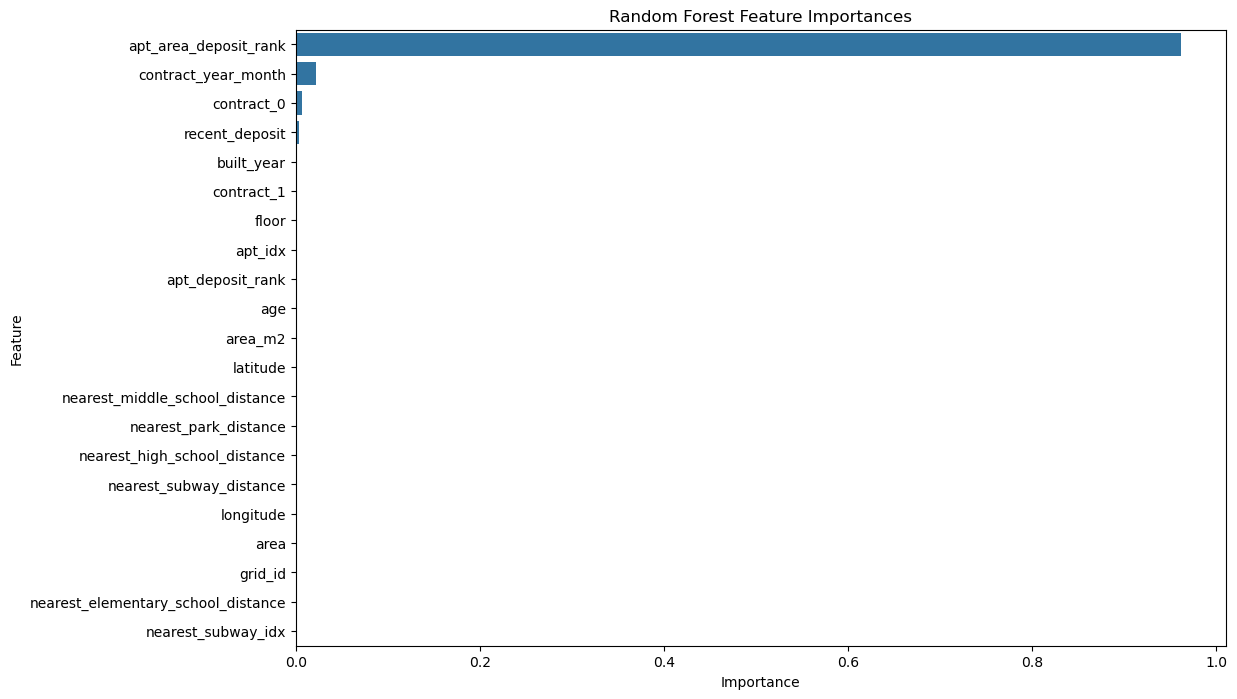

In [21]:
# 피처 임포턴스 추출
importances = rf_model.feature_importances_
feature_names = X_train.columns

# 피처 임포턴스를 데이터프레임으로 변환
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# 중요도 순으로 정렬
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# 시각화
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Random Forest Feature Importances')
plt.show()

### Stacking

In [22]:
# 검증 세트의 예측을 메타 모델의 입력으로 결합
meta_X_train = np.column_stack((xgb_val_pred, lgb_val_pred, rf_val_pred))
meta_y_train = y_val

# 테스트 세트의 예측을 메타 모델의 입력으로 결합
meta_X_test = np.column_stack((xgb_test_pred, lgb_test_pred, rf_test_pred))

# 선형 회귀 메타 모델 초기화
meta_model = LinearRegression()

# 메타 모델 학습
meta_model.fit(meta_X_train, meta_y_train)

# 메타 모델의 Train MAE 계산
meta_train_pred = meta_model.predict(meta_X_train)
train_meta_mae = mean_absolute_error(meta_y_train, meta_train_pred)
print(f"Meta Model Train MAE: {train_meta_mae:.4f}")

# 최종 예측 수행
final_pred = meta_model.predict(meta_X_test)

Meta Model Train MAE: 3968.7547


In [23]:
final_pred

array([21682.23652115,  7134.09390125,  5727.38930486, ...,
       44596.71169338, 36493.9506557 , 37373.9026241 ])

In [13]:
# Create a DataFrame from y_pred with the same index as X_test
final_pred_df = pd.DataFrame(final_pred, index=range(len(final_pred)), columns=['deposit'])

# Display the DataFrame
final_pred_df.index.name = 'index'
final_pred_df

,deposit
index,
0,21682.236521
1,7134.093901
2,5727.389305
3,5545.873804
4,5824.961206
...,...
150167,37249.225053
150168,44110.232729
150169,44596.711693


In [15]:
final_pred_df['deposit'].mean()

np.float64(38891.75210329673)

In [16]:
final_pred_df.to_csv(os.path.join(submission_path, "v4_Stacking_linear_xgb+lgb+rf_2.csv"), index=True)